---
title: "Temporal Evolution"
author: "Ali Zaidi"
date: "2025-11-27"
categories: [Data Engineering]
description: "All of that is useful but since we're working with sequence data of a video, we can't leave out changes over time of how these keypoints evolve in the swing"
format:
  html:
    code-fold: true
jupyter: python3
---

In [1]:
#| include: false 
from fastai.vision.all import *
from eagle_swing.clipper import *
from eagle_swing.plot import *
from eagle_swing.temporal import *
%matplotlib widget

Key Technical Notes for Golf Analysis <br>
	1.	Noise & Smoothing: Raw pose estimation outputs (like MMPose/YOLO) usually contain high-frequency jitter. Taking the derivative ( np.gradient ) amplifies this noise. It is highly recommended to apply a Savitzky-Golay filter or a Butterworth low-pass filter to the raw keypoints before passing them to this function. <br>
	2.	Vector Projection vs. Derivative: <br>
	-	Derivative Method (Used above): . Simple and robust for general separation analysis. <br>
	-	Projection Method: . This projects the relative velocity vector onto the line connecting the two points. It is mathematically equivalent but requires calculating velocity vectors first, which adds complexity. <br>
	3.	Interpretation: In a golf swing, this metric is useful for “X-Factor” analysis (separation between hips and shoulders) or measuring how quickly the hands move away from the body center during the downswing (radius extension).

2) Velocity of angle
    - Angular speed of a joint -- is the right elbow hitting 90 degrees faster on a 5 swing that a 1 swing?

In [2]:
#| include: false 
pkl_files = get_files('../../../data/full_videos/saugusta/', extensions='.pkl')
len(pkl_files)

7

3) Acceleration of distance and angle:
    - the second derivative tells you the rate of change of velocity, could be useful at transition points and much more <br>
    --> https://www.perplexity.ai/search/58255efe-03e6-48b0-87c3-0ffdc6c75edf

In [3]:
df = pd.read_csv('../../posts/new_golfer/stef_lbls.csv').reset_index(drop=True)
before_increment = 45
after_increment = 45
df['start_idx'] = df.first_highest_wrist_idx - before_increment
df['end_idx'] = df.first_highest_wrist_idx + after_increment

In [4]:
df5 = df[df.score == 5].reset_index(drop=True)
df1 = df[df.score == 1].reset_index(drop=True)
df_low_high = pd.concat([df1, df5], ignore_index=True)
df_low_high.head(2)

,clip_name,video_name,swing_idx,score,pkl_path,first_highest_wrist_idx,start_idx,end_idx
0,IMG_1170_swing_0_score_1,IMG_1170,0,1,../../../data/full_videos/saugusta/IMG_1170/keypoints/IMG_1170.pkl,1525,1480,1570
1,IMG_1173_swing_4_score_1,IMG_1173,4,1,../../../data/full_videos/saugusta/IMG_1173/keypoints/IMG_1173.pkl,7212,7167,7257


In [5]:
before_increment = 45
after_increment = 45
df_low_high['start_idx'] = df_low_high.first_highest_wrist_idx - before_increment
df_low_high['end_idx'] = df_low_high.first_highest_wrist_idx + after_increment

In [6]:
rows = []
#for idx, row in df_low_high.iterrows():
for idx, row in df.iterrows():
    rows.append(row)
scores = [x.score for x in rows]

In [7]:
kps_holder = [KpExtractor(row.pkl_path).kps[row.start_idx: row.end_idx+30] for row in rows]# if row.video_name == 'IMG_1167']

In [8]:
#rows[3].video_name

In [9]:
frames, fps = get_frames(f"{rows[3].pkl_path[:-3]}mp4", num_frames=None)
frames.shape

100%|██████████████████████| 7261/7261 [00:13<00:00, 549.44it/s]


(7261, 256, 256, 3)

In [10]:
animate_keypoints_interactive(kps_holder[:], vertical=False,
                              dark_mode=True, )

In [11]:
# top of downswing
top_of_swing_idx = [find_last_frame_before_downswing(kps) for kps in kps_holder]
#top_of_swing_idx

In [12]:
# after contact as swing finishes
finish_downswing_idx = [find_last_frame_wrist_is_right(kps) for kps in kps_holder]
#finish_downswing_idx

In [13]:
downswing_frames = np.array(finish_downswing_idx) - np.array(top_of_swing_idx)
#downswing_frames

In [14]:
#scores

In [15]:
speed_df = pd.DataFrame([scores, downswing_frames], index=['score', 'number_of_frames']).T
speed_df.shape

(35, 2)

/tmp/ipykernel_14019/1142253455.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


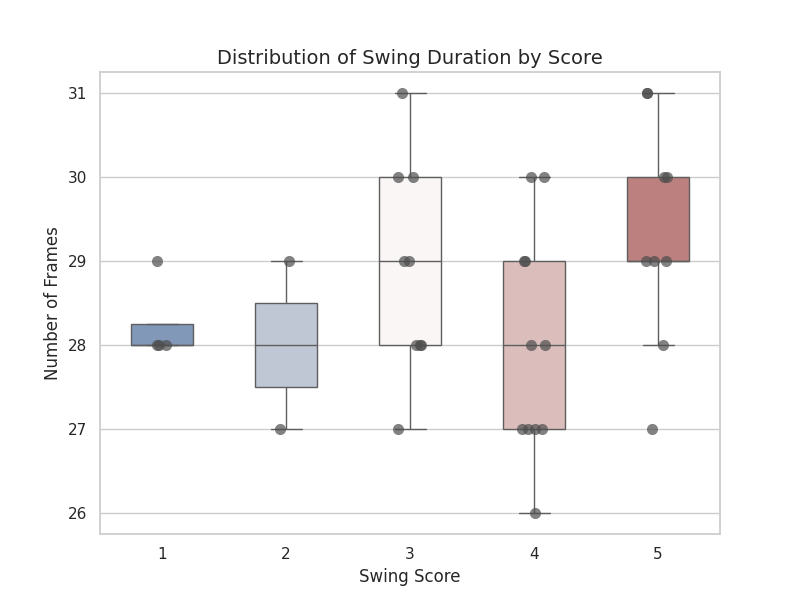

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Recreating your dataframe

# 2. Setup the plot style
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 6))

# 3. Create a Box Plot (shows the summary stats)
ax = sns.boxplot(
    x="score", 
    y="number_of_frames", 
    data=speed_df, 
    showfliers=False,  # Hide outliers from boxplot (points will show them)
    width=0.5,
    palette="vlag"
)

# 4. Overlay a Strip Plot (shows the raw data points with jitter)
sns.stripplot(
    x="score", 
    y="number_of_frames", 
    data=speed_df, 
    size=8, 
    color=".3", 
    linewidth=0, 
    alpha=0.7,
    jitter=True  # Spreads points out so they don't overlap
)

# 5. Final formatting
plt.title('Distribution of Swing Duration by Score', fontsize=14)
plt.xlabel('Swing Score', fontsize=12)
plt.ylabel('Number of Frames', fontsize=12)
plt.show()

array([[<Axes: title={'center': 'score'}>,
        <Axes: title={'center': 'number_of_frames'}>]], dtype=object)

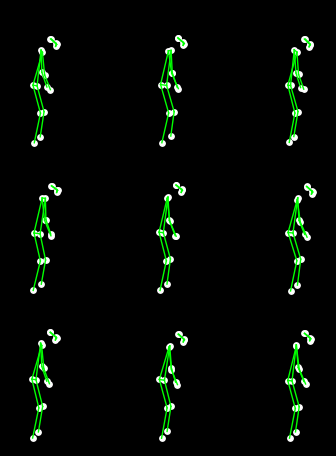

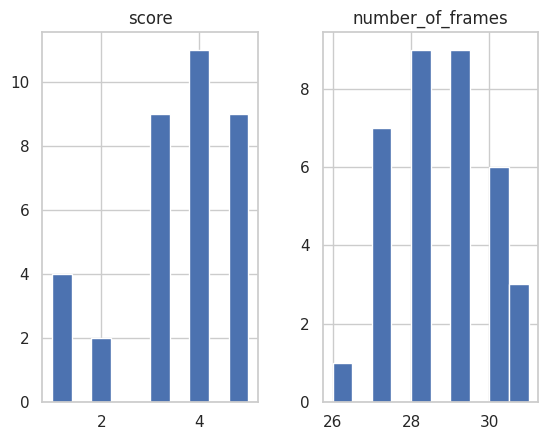

In [17]:
%matplotlib inline
speed_df.hist()

In [18]:
[find_crossing_frames(kps) for kps in kps_holder]

IndexError: list index out of range

In [ ]:
def get_signed_distance(p_hand, p_shoulder, p_hip):
    """
    Returns > 0 if hand is to the RIGHT of the shoulder-hip line.
    Returns < 0 if hand is to the LEFT of the shoulder-hip line.
    Uses a vertical boundary when the hand is above the shoulder.
    """
    x_h, y_h = p_hand[:2]
    x_s, y_s = p_shoulder[:2]
    x_hip, y_hip = p_hip[:2]
    
    # 1. Vertical Projection Fix:
    # If hand is above the shoulder (y_h < y_s in image coords), 
    # use the shoulder's X as the vertical boundary.
    if y_h < y_s:
        return x_h - x_s

    # 2. Standard Line Projection (Below Shoulder):
    # Avoid division by zero
    if abs(y_hip - y_s) < 1e-6: 
        return x_h - x_s 
        
    # Calculate x of the body line at the hand's y-coordinate
    slope_inv = (x_hip - x_s) / (y_hip - y_s)
    x_line_at_hand_y = x_s + (y_h - y_s) * slope_inv
    
    return x_h - x_line_at_hand_y

def find_crossing_frames(keypoints):
    """
    Identifies frames where hands cross body lines in a specific direction (Right -> Left).
    
    Args:
        keypoints: Numpy array of shape (num_frames, num_kps, 2)
    
    Returns:
        dict: Lists of frame indices where the crossing event completes.
    """
    # COCO Indices
    L_SHOULDER, L_HIP = 5, 11
    R_SHOULDER, R_HIP = 6, 12
    L_HAND, R_HAND = 9, 10  # Using Wrists as proxies for Hands

    events = {
        'right_hand_crosses_left_body': [], # Right Hand crossing Left Body Line
        'left_hand_crosses_right_body': []  # Left Hand crossing Right Body Line
    } 
    holder = []
    # Iterate through frames
    for t in range(len(keypoints) - 1):
        kp_curr = keypoints[t]
        kp_next = keypoints[t+1]

        # --- Check 1: Right Hand crossing Left Body Line (Right -> Left) ---
        dist_curr = get_signed_distance(kp_curr[R_HAND], kp_curr[L_SHOULDER], kp_curr[L_HIP])
        dist_next = get_signed_distance(kp_next[R_HAND], kp_next[L_SHOULDER], kp_next[L_HIP])
        
        # Check for transition from Positive (Right) to Negative (Left)
        if dist_curr > 0 and dist_next <= 0:
            events['right_hand_crosses_left_body'].append(t + 1)
            holder.append(t)

        # --- Check 2: Left Hand crossing Right Body Line (Right -> Left) ---
        dist_curr_l = get_signed_distance(kp_curr[L_HAND], kp_curr[R_SHOULDER], kp_curr[R_HIP])
        dist_next_l = get_signed_distance(kp_next[L_HAND], kp_next[R_SHOULDER], kp_next[R_HIP])
        
        # Check for transition from Positive (Right) to Negative (Left)
        if dist_curr_l > 0 and dist_next_l <= 0:
            events['left_hand_crosses_right_body'].append(t + 1)

    events['time_between_crossing'] = holder[-1] - holder[-2]

    return events